In [1]:
import random
import numpy as np
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import networkx as nx

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from keras.models import load_model
import pickle


In [2]:
def calculate_ratios_invest(data):
    p = []
    total_count = len(data)
    type_ = ['buy','sell','hold']

    for i in range(3):
        if total_count == 0:
            p.append(0)
        else:
            p.append(round(data.count(type_[i]) / total_count,2))
    return p


def calculate_ratios_num(data):
    p = []
    total_count = len(data)
    for i in range(10):
        if total_count == 0:
            p.append(0)
        else:
            p.append(round(data.count(i) / total_count,2))

    return p

def calculate_ratios_price(data,mean_price):
    p = []
    total_count = len(data)
    for i in range(10):
        if total_count == 0:
            p.append(0)
        else:
            p.append(round(data.count(mean_price-5+i) / total_count,2))

    return p

def moving_average(lst):
    window=100
    ret = []
    for i in range(len(lst)):
        if i < window:
            ret.append(sum(lst[:i+1])/(i+1))
        else:
            ret.append(sum(lst[i-window+1:i+1])/window)
    return ret

In [3]:
class DQN:
    def __init__(self, person_id,gamma=0.99, epsilon=0.1, batch_size=32,model_type = None):
        random.seed(None)
        np.random.seed(None)
        if model_type == 'lite':
            self.model = self.build_dqn_lite()
        elif model_type == 'hard':
            self.model = self.build_dqn_hard()
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = []  
        self.model_type = model_type
        
        
    def build_dqn_lite(self):
        input_layer = Input(shape=(37,))

        hidden_layer = Dense(32, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform')(input_layer)


        output_layer_1 = Dense(3, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        output_layer_2 = Dense(10, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        output_layer_3 = Dense(9, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer) 

        model = Model(inputs=input_layer, outputs = [output_layer_1,output_layer_2,output_layer_3])
        model.compile(loss='mse', optimizer=Adam())
        return model
        
    def build_dqn_hard(self):

        input_layer = Input(shape=(37,))

        hidden_layer = Dense(256, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform')(input_layer)
        hidden_layer = Dense(128, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        hidden_layer = Dense(32, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        hidden_layer = Dense(12, activation='relu',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)


        output_layer_1 = Dense(3, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        output_layer_2 = Dense(10, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer)
        output_layer_3 = Dense(9, activation='linear',kernel_initializer='random_uniform', bias_initializer='random_uniform')(hidden_layer) 

        model = Model(inputs=input_layer, outputs = [output_layer_1,output_layer_2,output_layer_3])
        model.compile(loss='mse', optimizer=Adam())
        return model

    
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return [self.env.action_space[i].sample() for i in range(2)]
        else:
            q_values = self.model.predict(state)
            return [np.argmax(q_values[i]) for i in range(2)]
      

    def train(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))
        
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            q_update = reward
            if not done:
                q_update = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            
            q_values = self.model.predict(state)
            q_values[action] = q_update

            self.model.fit(state, q_values, verbose=0)

In [14]:
class Person: # 개인의 주체
    def __init__(self, person_id , total_capital, holding_stock_num, env,model_type = None):
        
        # 네트워크속에서의 노드 정보
        self.person_id = person_id # 개인의 번호
        
        
        self.try_experience = 1     # 개인의 현재 경험
        self.experience_data = []   # 개인의 경험 데이터

        
        
        # 주식시장내에서의 정보
        self.total_capital = total_capital       # 개인의 자본
        self.investable_capital = total_capital    # 개인의 투자가능 자본
        self.holding_stock_num = holding_stock_num  # 개인의 holding 수
        self.env = env                              # 환경
        if model_type == 'lite':
            self.agent = DQN(env,person_id,model_type = 'lite') # 에이전트 정의
        elif model_type == 'hard':
            self.agent = DQN(env,person_id,model_type = 'hard') # 에이전트 정의 

            
    def can_invest(self, order_num, order_price, order_type): # 거래 가능한지 파악
        if order_type == 'buy':     
            return (self.investable_capital // order_price) >= order_num
        elif order_type == 'sell':
            return (self.holding_stock_num) >= order_num
        else:
            return False #hold 일때
        
        return True

    def buy_first(self, order_num): # 초기 주식 구매
        self.investable_capital -= order_num * self.env.get_price() # 거래가능자본
        self.holding_stock_num += order_num
        self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price() # 총보유자본

    def buy(self, order_num, order_price, invest_able_for_market=None):# None 값 : 거래주문 거래소에 넣을떄 /Ture : 실제 거래소에서 거래 성사되었을때 / False 실제 거래소에서 거래 실패했을때
        if invest_able_for_market is None:
            if self.can_invest(order_num, order_price, 'buy'): # invest_able_for_market 적으면 주문성사된것대로 자본업데이트 하기 
                self.env.add_invest(self.person_id, 'buy', order_num, order_price) #거래소에 거래 넣어보기 
            else:# 개인자본 문제로 거래 성사 실패시
                self.env.add_invest(self.person_id, 'hold', order_num, order_price)#거래소에 거래 넣기전에 자본 문제로 실패
        else: # 실제 거래소에서 거래 성립했을떄
            if invest_able_for_market:#거래소에 거래 성공
                self.investable_capital -= order_num * order_price
                self.holding_stock_num += order_num
                self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price()
            else:#거래소에 거래 실패
                self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price()
    
    def sell(self, order_num, order_price, invest_able_for_market=None):
        if invest_able_for_market is None:
            if self.can_invest(order_num, order_price, 'sell'):
                self.env.add_invest(self.person_id, 'sell', order_num, order_price)
            else:
                self.env.add_invest(self.person_id,'hold', order_num, order_price)
        else:
            if invest_able_for_market:
                self.investable_capital += order_num * order_price
                self.holding_stock_num -= order_num
                self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price()
            else:
                self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price()
   
    def hold(self, order_num, order_price, invest_able_for_market=None):
        if invest_able_for_market is None:
            self.env.add_invest(self.person_id, 'hold', order_num, order_price)
        else:
            # 주문이 성사되었을 때
            self.investable_capital += order_num * order_price
            self.holding_stock_num -= order_num
            self.total_capital = self.investable_capital + self.holding_stock_num * self.env.get_price()
            
            
            
    def sum_1(self,probabilities):
        abs_probabilities = [abs(p) for p in probabilities]
        total = sum(abs_probabilities)
        normalized_probabilities = [abs(p)/total for p in abs_probabilities]
        
        return normalized_probabilities
            
            
    def real_invest(self,state): #모델 주문
        Q_values = self.agent.model.predict(state, verbose=0)

        action_1 = np.random.choice([0,1,2], p=self.sum_1(Q_values[0][0]))
        action_2 = np.random.choice([0,1,2,3,4,5,6,7,8,9], p=self.sum_1(Q_values[1][0]))
        action_3 = np.random.choice([0,1,2,3,4,5,6,7,8], p=self.sum_1(Q_values[2][0]))
    
        order_type = ['buy','sell','hold'][action_1]
        order_num = [1,2,3,4,5,6,7,8,9,10][action_2]
        order_price = env.stock_price + [-4,-3,-2,-1,0,1,2,3,4][action_3]

        if order_type == 'hold':
            order_num = 0
            order_price = 0


        getattr(person,order_type)(order_num, order_price, invest_able_for_market=None)
        return Q_values,[action_1,action_2,action_3]
    
            
    def real_agent_invest(self,state): #모델 주문
        Q_values = self.agent.model.predict(state, verbose=0)
        action_1 = np.argmax(Q_values[0])
        action_2 = np.argmax(Q_values[1])
        action_3 = np.argmax(Q_values[2])

        order_type = ['buy','sell','hold'][action_1]
        order_num = [1,2,3,4,5,6,7,8,9,10][action_2]
        order_price = env.stock_price + [-4,-3,-2,-1,0,1,2,3,4][action_3]
        
        order_type = 'sell'
        order_num = 10
        order_price = env.stock_price 

#         if order_type == 'hold':
#             order_num = 0
#             order_price = 0
                        

        getattr(person,order_type)(order_num, order_price, invest_able_for_market=None)
        return [action_1,action_2,action_3]

    def random_invest(self): # 랜덤 주문
        Q_values = self.agent.model.predict(state, verbose=0)
        action_1 = np.random.choice([0,1,2])
        action_2 = np.random.choice([0,1,2,3,4,5,6,7,8,9])
        action_3 = np.random.choice([0,1,2,3,4,5,6,7,8])
        
        order_type = ['buy', 'sell', 'hold'][action_1]
        order_num = [1,2,3,4,5,6,7,8,9,10][action_2]
        order_price = self.env.get_price() + [-4,-3,-2,-1,0,1,2,3,4][action_3] # 값이 0보다작아져서 추천해주면 변경 최소선
        getattr(self,order_type)(order_num, order_price, invest_able_for_market=None) # 거래소에 거래 넣기 
        return Q_values,[action_1,action_2,action_3]
        
    def reset(self,total_capital):
        # 네트워크속에서의 노드 정보
#         self.person_id = person_id # 개인의 번호
        
        
        self.try_experience = 1     # 개인의 현재 경험
        self.experience_data = []   # 개인의 경험 데이터


        
        # 주식시장내에서의 정보
        self.total_capital = total_capital       # 개인의 자본
        self.investable_capital = total_capital    # 개인의 투자가능 자본
        self.holding_stock_num = 0  # 개인의 holding 수
        

In [4]:
import copy
class Environment:  # 환경 구성
    def __init__(self,person_num,agent_num,step):
        self.steps = step            #스텝수
        self.person_num = person_num #사람수
        self.agent_num = agent_num   #모델수
        self.total_person_num = self.person_num + self.agent_num # 총 인원
        self.initial_price = 10000  # 시작수
        self.person_dict = {}       # 사람 리스트
        self.information_all = {}   # 총 정보 
        self.information_individual = {}  # 개인의 정보 리스트 썼다 지웠다
        self.step = 1  # 현재 스텝수

        self.stock_price = 100 # 현재 주식 가격
        self.invest_list = [] # 주식 거래 정보
        self.stock_price_list = [] # 주식 가격 리스트
        self.total_capital_list = []
        self.holding_stock_num = []
        self.agent_num = agent_num
        self.total_invest = []
        self.stock_price_list = []
        self.dataes = []
        self.target_data = []
        self.target_id = 0
        
        
    def reset(self):
        self.person_num = self.person_num #사람수
        self.agent_num = self.agent_num   #모델수
        self.total_person_num = self.person_num + self.agent_num # 총 인원
        self.initial_price = 10000  # 시작수
        self.information_all = {}   # 총 정보 
        self.information_individual = {}  # 개인의 정보 리스트 썼다 지웠다
        self.step = 1  # 현재 스텝수

        self.stock_price = 100 # 현재 주식 가격
        self.invest_list = [] # 주식 거래 정보
        self.stock_price_list = [] # 주식 가격 리스트
        self.total_capital_list = []
        self.holding_stock_num = []
        self.total_invest = []
        self.stock_price_list = []
        self.dataes = []
        self.target_data = []
        self.target_id = 0
        
        

        total_capital = 100000
        holding_stock_num = 0
        for person in list(self.person_dict.values()):
            person.reset(total_capital)
        
        input_layer = np.expand_dims(np.random.rand(37), 0)


        self.state = input_layer
        return self.state

    def create_person(self,target_model_id): # 사람 생성
        holding_stock_num = 0
        total_capital = 100000
        for i in range(self.person_num):
            if i == target_model_id:
                model_type = 'hard'
            else:
                model_type = 'lite'
            person_id = i
            person = Person(person_id , total_capital, holding_stock_num, self, model_type) # person_id 1부터 생성
            self.add_person(person)

    def save_person_information(self):
        t_c = []
        h_s_n = []
        for i in self.person_dict:
            t_c.append(self.person_dict[i].total_capital)
            h_s_n.append(self.person_dict[i].holding_stock_num)
            
        self.total_capital_list.append(t_c)
        self.holding_stock_num.append(h_s_n)
        self.stock_price_list.append(env.stock_price)
        
    def get_price(self):
        return self.stock_price
        
    def set_add_price(self, price):
        self.stock_price_list.append(price)
                
    def add_person(self, person): # 새로운 사람 생성
        self.person_dict[person.person_id] = person
        
    def set_price(self, price):
        self.stock_price = price
        
    def add_invest(self, person_id,order_type, order_num, order_price):
        invest = {
            "person_id": person_id,
            "order_type": order_type,
            "order_num": order_num,
            "order_price": order_price,
        }
        self.invest_list.append(invest)
    
        
    def get_past(self,n):
        return self.invest_list[n:]
    
    def get_past_prices(self, window_size):
        if len(self.stock_price_list[-window_size-1:-1]) < 10:
            return np.array([100 for i in range(10)])
        return np.array(self.stock_price_list[-window_size-1:-1])

    def invest(self,target_id):
        investable_price = []
        self.invest_list = sorted(self.invest_list, key=lambda x: x['order_price'], reverse=True) # 높은것 먼저 순서대로

        for me in self.invest_list:
            before_len = len(self.invest_list)
            for other in self.invest_list:
                if me['order_type'] in ['buy','sell'] and other['order_type'] in ['buy','sell'] and me['order_type'] != other['order_type'] and me['order_price'] == other['order_price'] :
                    min_order_num = min(me['order_num'],other['order_num'])
                    getattr(self.person_dict[me['person_id']],me['order_type'])(min_order_num,  me['order_price'], invest_able_for_market=True) # 거래 성사시
                    getattr(self.person_dict[other['person_id']],other['order_type'])(min_order_num,  me['order_price'], invest_able_for_market=True) # 거래 성사시
                    self.invest_list.remove(me)
                    self.invest_list.remove(other)
                    investable_price.append(me['order_price'])
                    break
            after_len = len(self.invest_list)

            if before_len != after_len:
                getattr(self.person_dict[me['person_id']],me['order_type'])(min_order_num,  me['order_price'], invest_able_for_market=False) # 거래 불가


        if len(investable_price) == 0:
            price = self.get_price()
        else:
            price = float(sum(investable_price)/len(investable_price))

        
        type_invest = []
        type_price = []
        type_num = []

        for bv in self.invest_list:
            type_invest.append(list(bv.values())[1])
            type_num.append(list(bv.values())[2])
            type_price.append(list(bv.values())[3])





        tt = []
        for ip in list(self.person_dict.values()):
            tt.append(ip.total_capital)
            
        if len(self.stock_price_list[-10:]) < 10:
            gkd = copy.deepcopy(self.stock_price_list[-10:])
            

            gkd = [100 for i in range(10-len(self.stock_price_list[-10:]))] + gkd
            
        else:
            gkd= self.stock_price_list[-10:]
            
            
        per = list(self.person_dict.values())[0]
        
            
        # 지금 현재 자기 순위 , 사람들 사고팔고 정도 , 사람들 개수 정도 , 사람들 단위 정도
        nested_list = [[per.total_capital] , [per.investable_capital] ,[per.holding_stock_num], gkd ,[tt[0]],calculate_ratios_invest(type_invest),calculate_ratios_num(type_num),calculate_ratios_price(type_price,self.stock_price)]
        
        
        
        
        
        
        self.state = np.array([[item for sublist in nested_list for item in sublist]])

        self.set_add_price(price)
        self.set_price(price)
        
#         return self.state ,  self.person_dict.values()[target_id].total_capital

        def rank_of_first_element(lst):
            first_element = lst[0]
            sorted_list = sorted(lst, reverse=False)  
            rank = sorted_list.index(first_element) + 1  
            return rank - 5

        
        
        self.invest_list = []
        
        result = rank_of_first_element(tt)
        

        total_reward = []
        for i in range(len(list(self.person_dict.values()))):
            total_reward.append(result)
#             total_reward.append(list(self.person_dict.values())[i].total_capital-100000 + result*200)
            
        return self.state ,total_reward[target_id]  # result*100 + # targetid 만 reward 변화
        
        
  
    def invest_start(self, first_start=None):# 스텝수 뺐음
        self.create_person()
        
        if first_start:
            for person in self.person_dict.values():
                person.buy_first(random.randint(10,20))
        
        for i in tqdm(range(self.steps)):
            for person,t in zip(self.person_dict.values(),range(len(self.person_dict.values()))): # 주문 생성
#                 if t == 0:
#                     getattr(person,order_type)(order_num, order_price, invest_able_for_market=None)
                person.random_invest() # 거래소에 주문 추가 
        
            self.total_invest.append(self.invest_list)
            self.invest() # 주문 거래소에서 시행
        
            self.save_person_information()
            
    def record_data(self,data):
        self.dataes.append(data)
            
            
    def update_Q(self,last_step_reward):
        model = self.person_dict[self.target_id].agent.model
        
        for data in self.dataes:
            Q_values_1 = data[2][0]
            Q_values_2 = data[2][1]
            Q_values_3 = data[2][2]

            Q_values_next = model.predict(data[3], verbose=0)

            Q_values_next_1 = Q_values_next[0]
            Q_values_next_2 = Q_values_next[1]
            Q_values_next_3 = Q_values_next[2]
            

            Q_values_1[0][data[1][0]] = last_step_reward + 0.95 * np.max(Q_values_next_1[0]) # gamma = 0.95
            Q_values_2[0][data[1][1]] = last_step_reward + 0.95 * np.max(Q_values_next_2[0]) # gamma = 0.95
            Q_values_3[0][data[1][2]] = last_step_reward + 0.95 * np.max(Q_values_next_3[0]) # gamma = 0.95

            self.target_data.append([data[0],[Q_values_1,Q_values_2,Q_values_3]])
        self.dataes = []
        
    def update_Q_last(self,last_step_reward):
        model = self.person_dict[self.target_id].agent.model
        
        for data in self.dataes:
            Q_values_1 = data[2][0]
            Q_values_2 = data[2][1]
            Q_values_3 = data[2][2]

            Q_values_next = model.predict(data[3], verbose=0)

            Q_values_next_1 = Q_values_next[0]
            Q_values_next_2 = Q_values_next[1]
            Q_values_next_3 = Q_values_next[2]
            

            Q_values_1[0][data[1][0]] = last_step_reward
            Q_values_2[0][data[1][1]] = last_step_reward 
            Q_values_3[0][data[1][2]] = last_step_reward 

            self.target_data.append([data[0],[Q_values_1,Q_values_2,Q_values_3]])
        self.dataes = []
            
    def train(self):
        if len(self.target_data) >64:
            model = self.person_dict[self.target_id].agent.model
            for batch in range(64):
                target_df = self.target_data[random.randint(0,len(self.target_data)-1)]
                model.fit(target_df[0],target_df[1], epochs=1, verbose=0)

            while len(self.target_data) >1000:
                del self.target_data[0]

In [5]:
def epsilon_decay(current_episode):
    initial_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.02
    
    total_episodes = 100
    
    epsilon = min_epsilon + (initial_epsilon - min_epsilon) * np.exp(-decay_rate * current_episode)
    return epsilon

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Episode: 162,epsilon :0.04955550767804736 Total Reward: 5


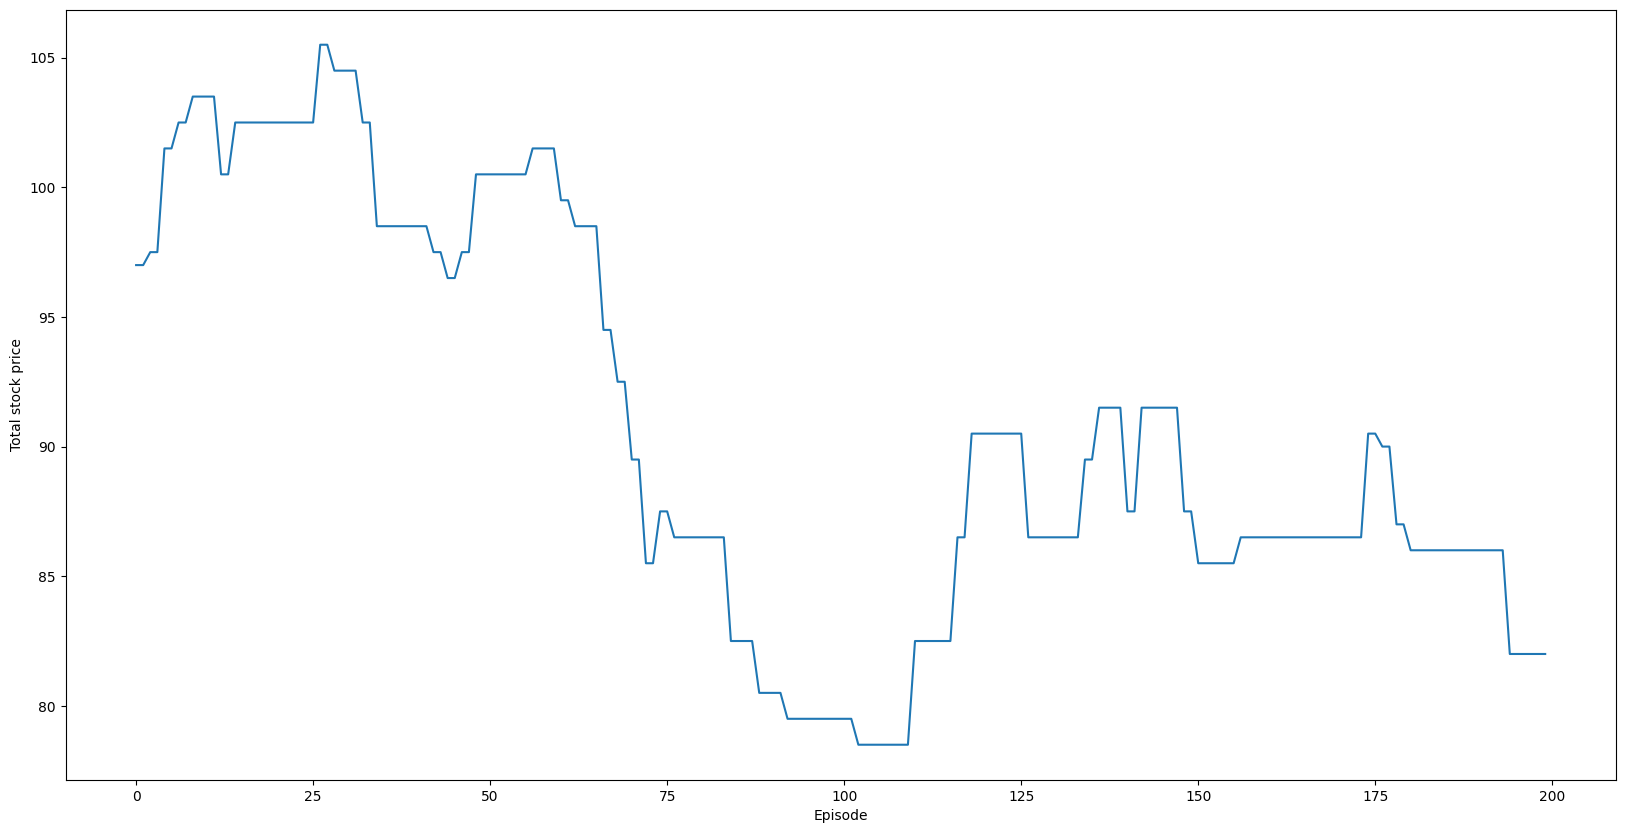

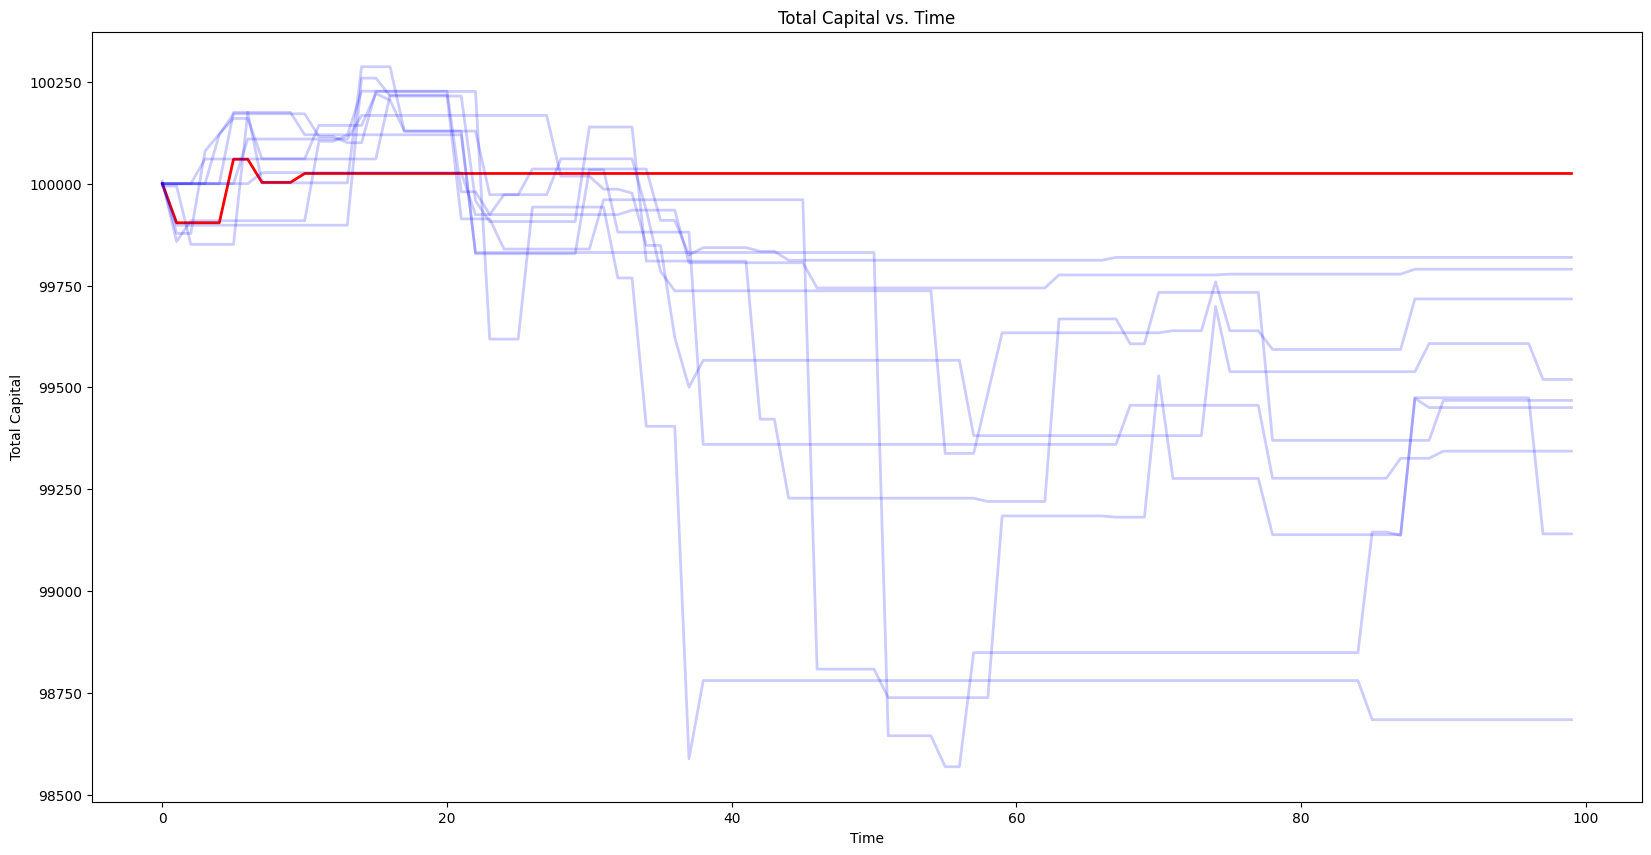

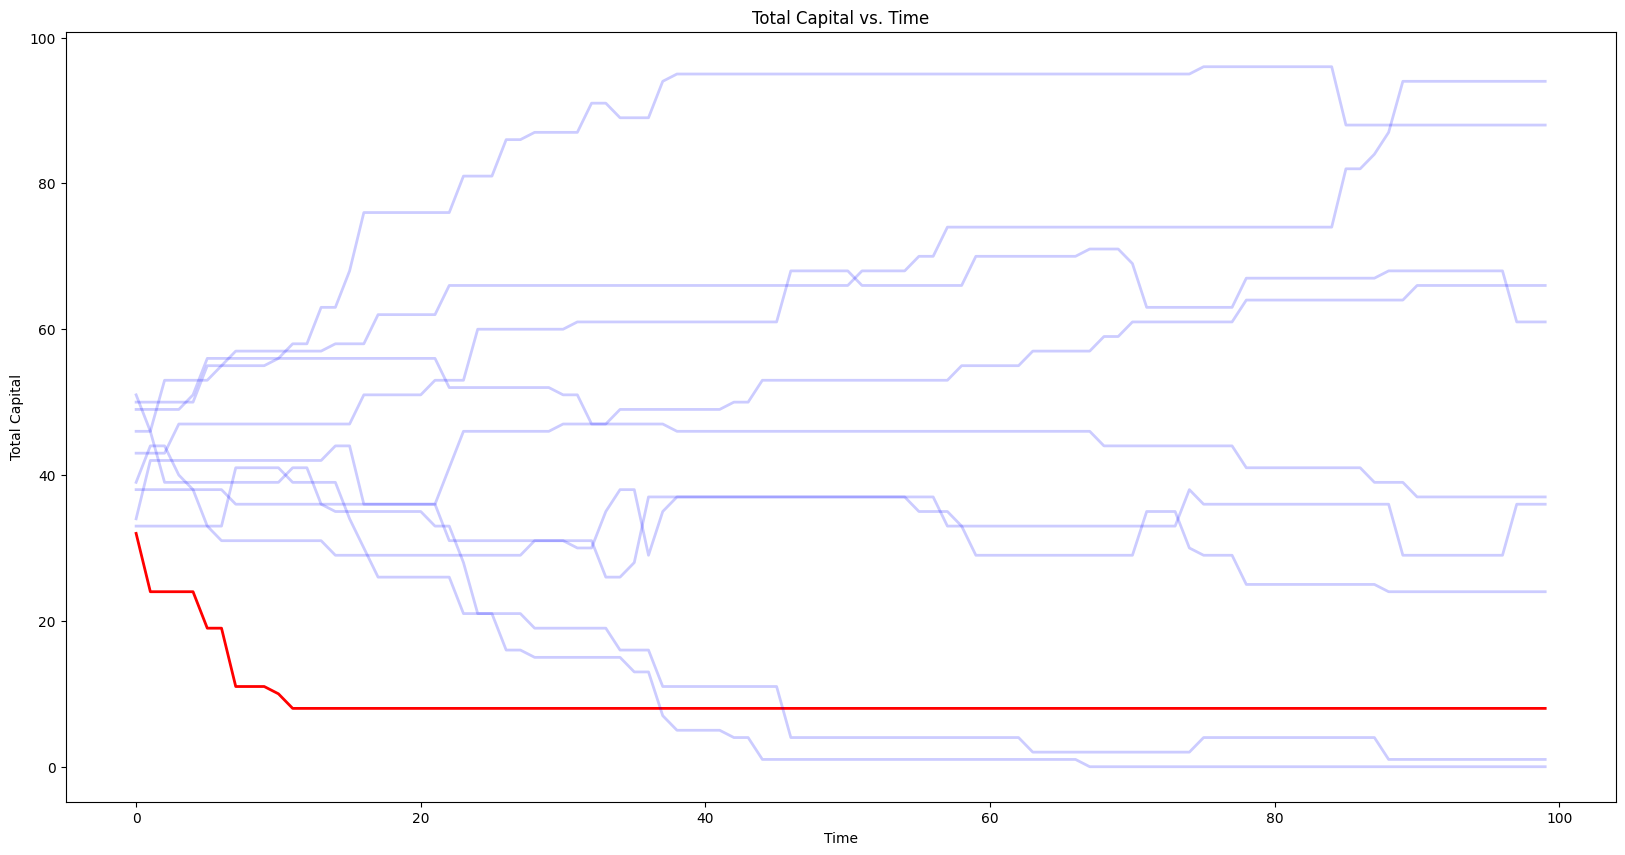

  1%|▍                                          | 1/100 [00:15<25:22, 15.38s/it]

Episode: 163,epsilon :0.0487722561479972 Total Reward: 2


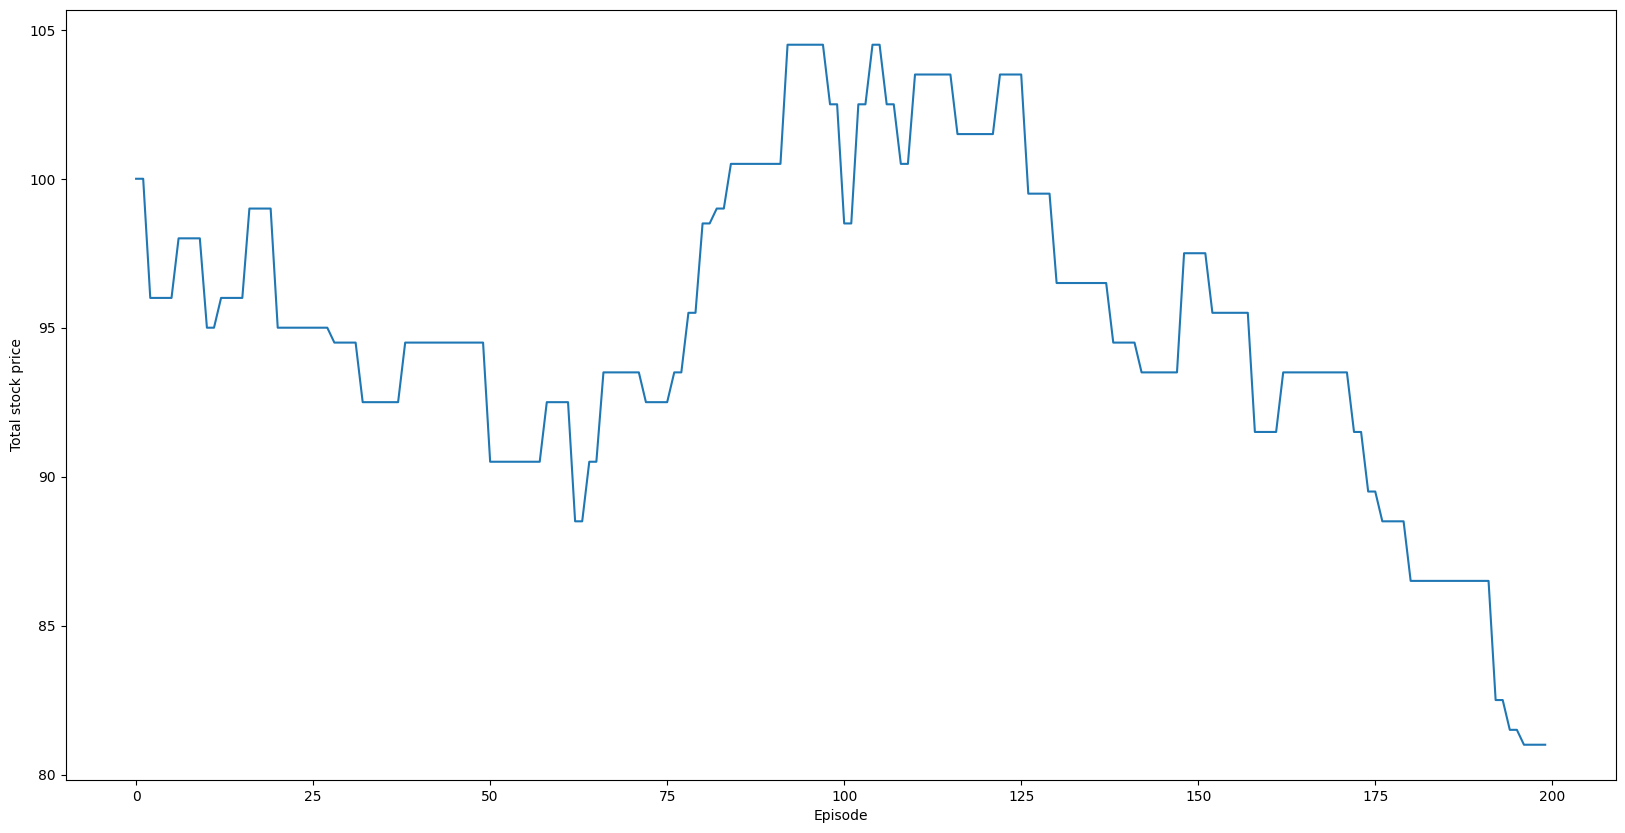

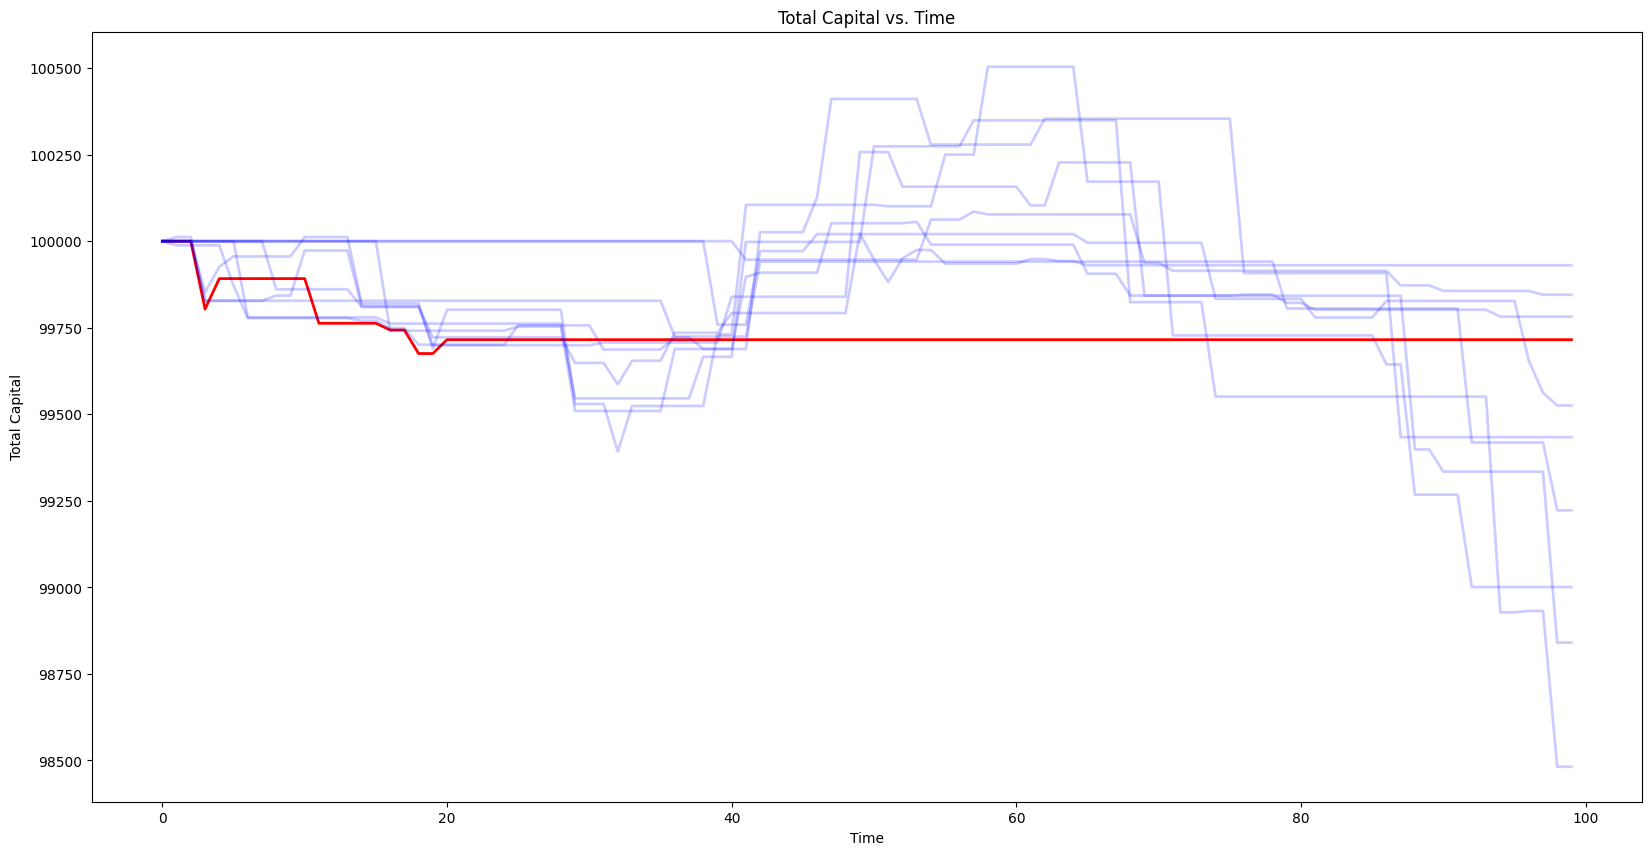

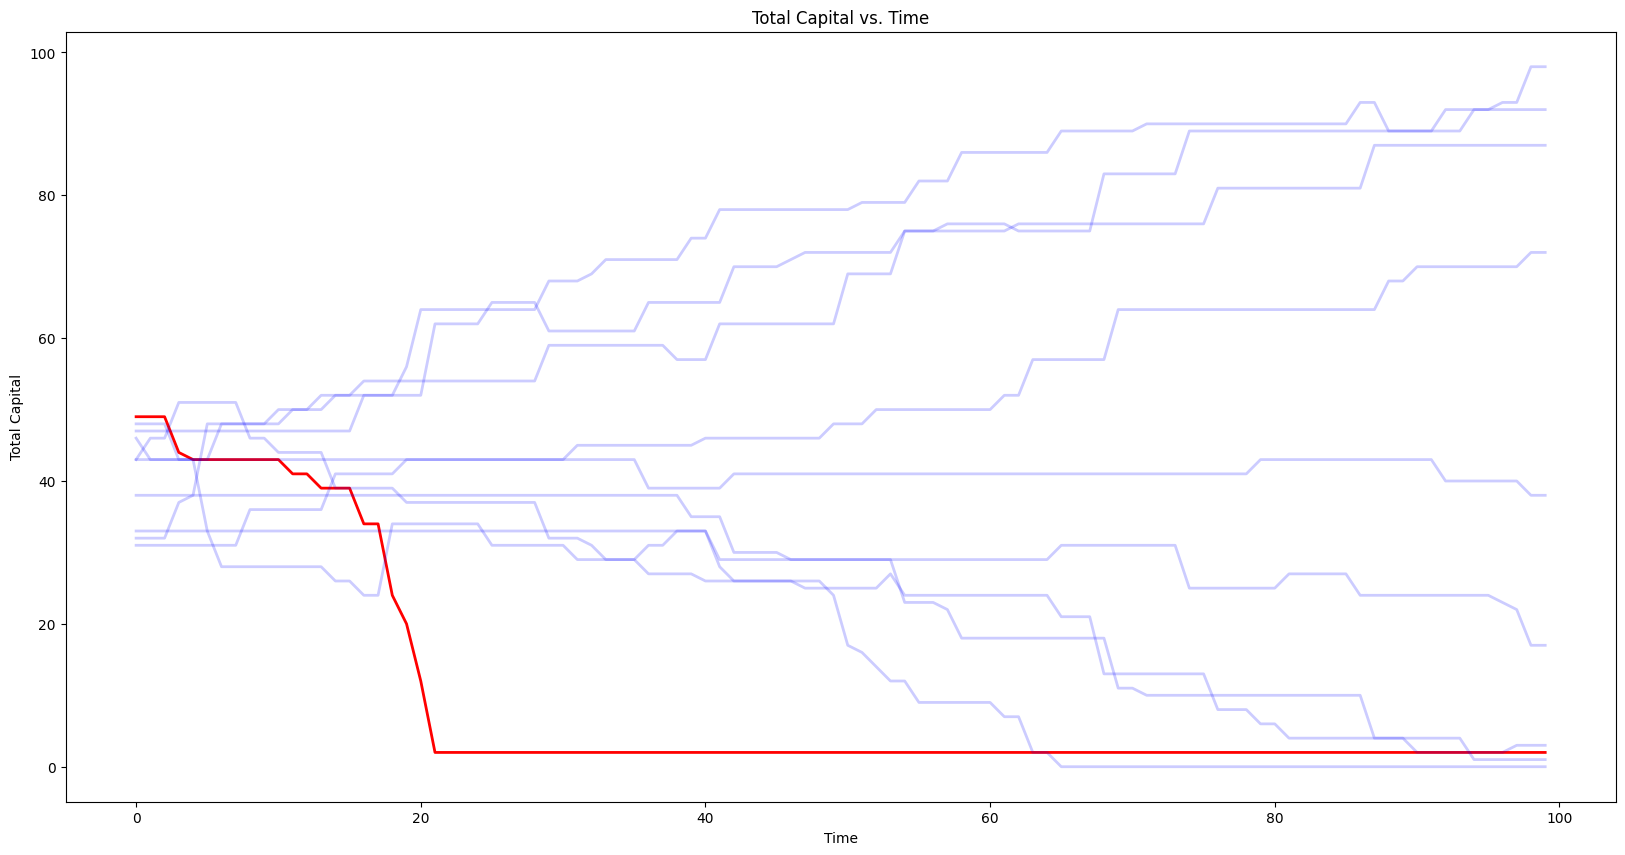

  2%|▊                                          | 2/100 [00:30<24:54, 15.25s/it]

Episode: 164,epsilon :0.04800451403737654 Total Reward: 5


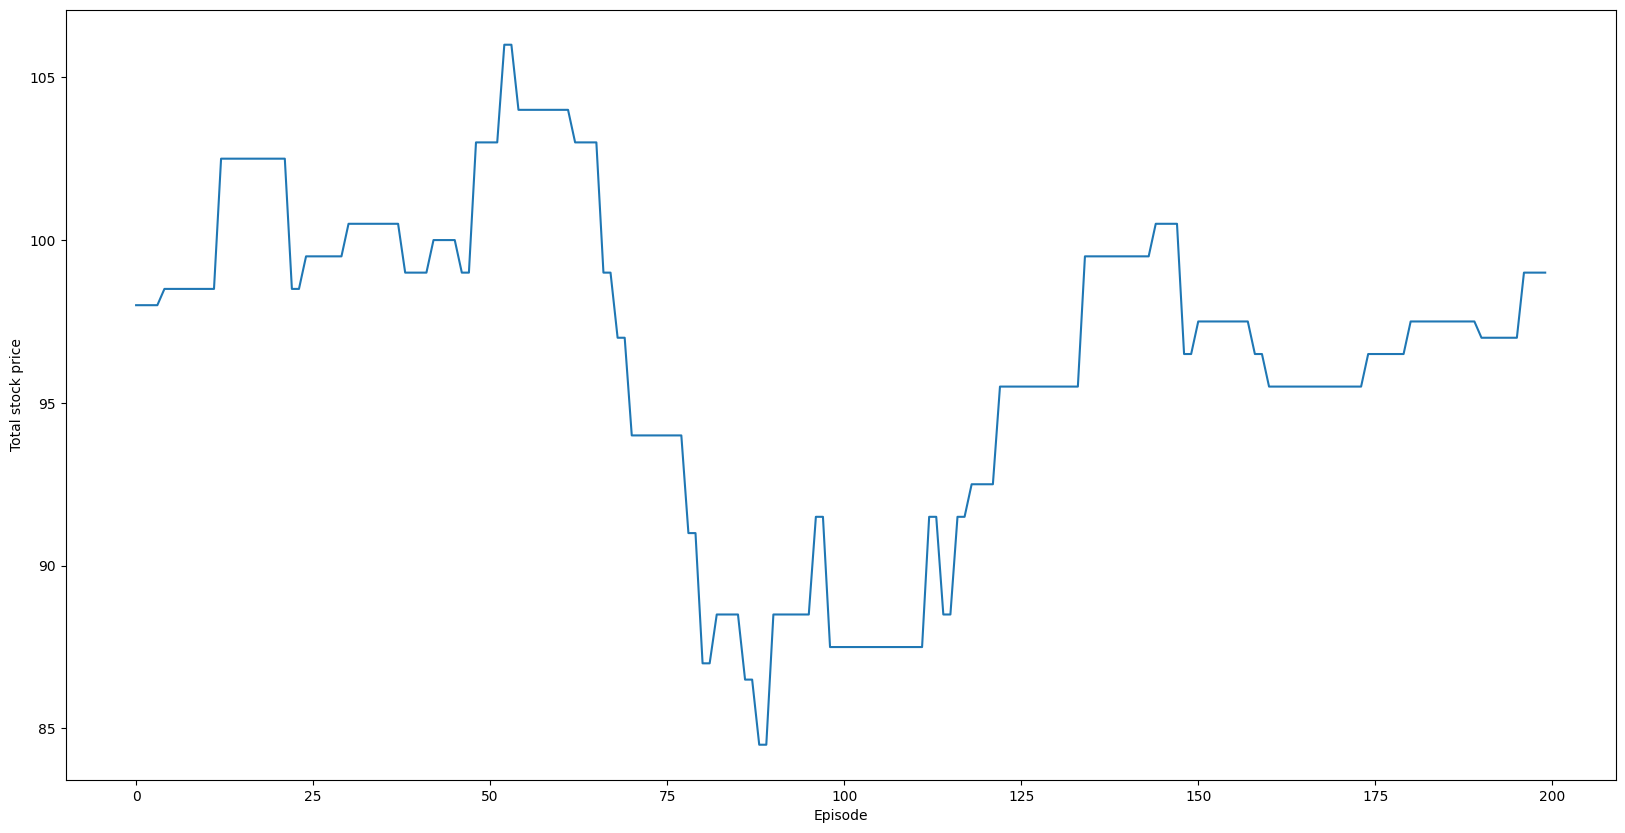

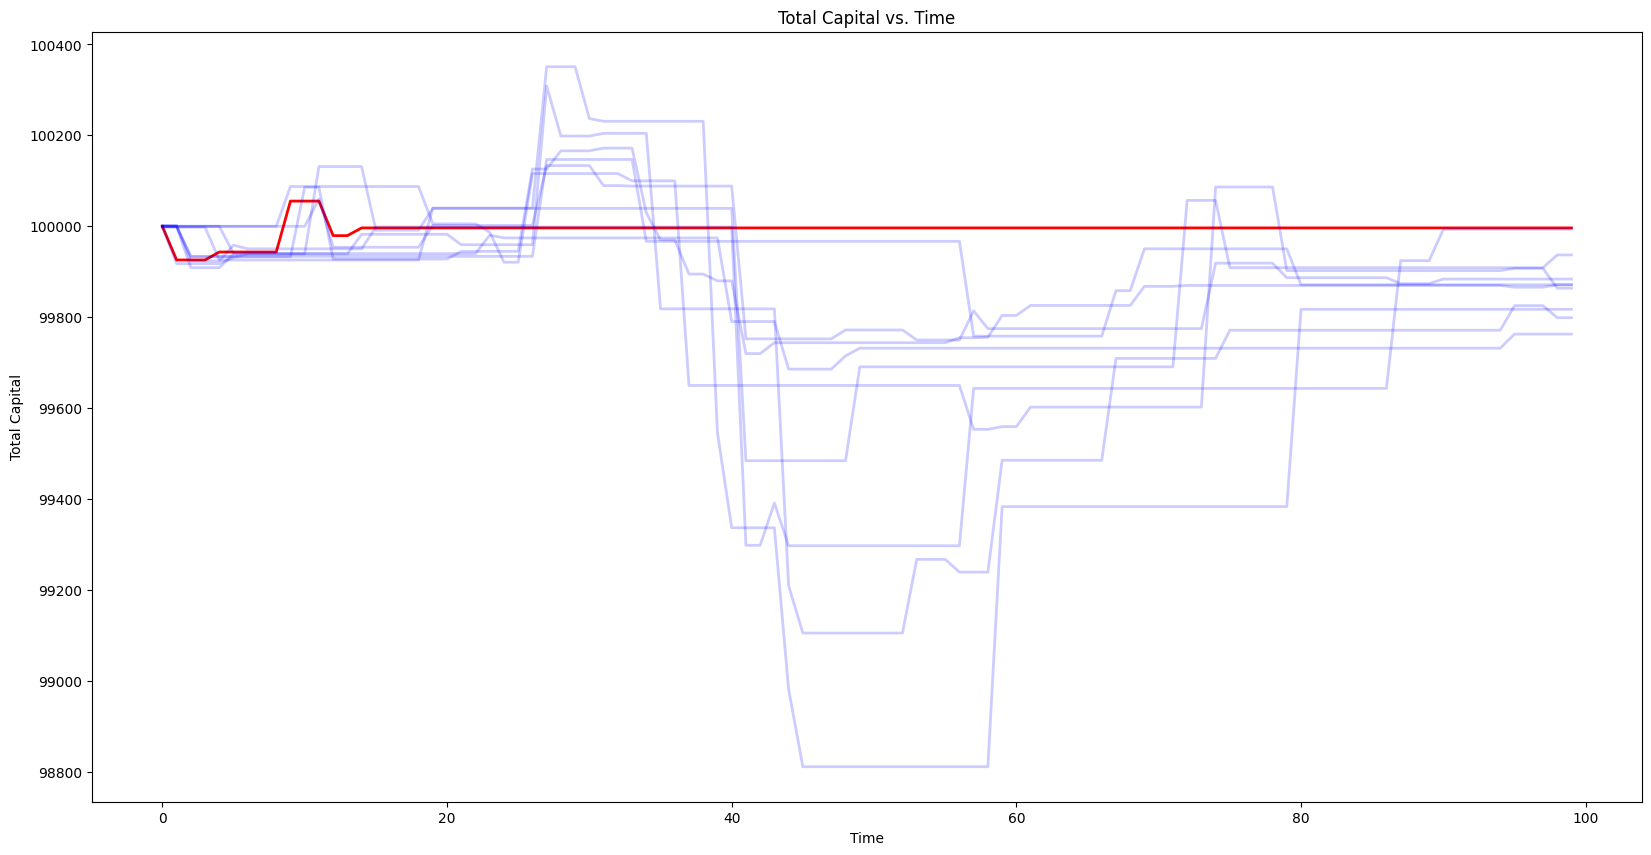

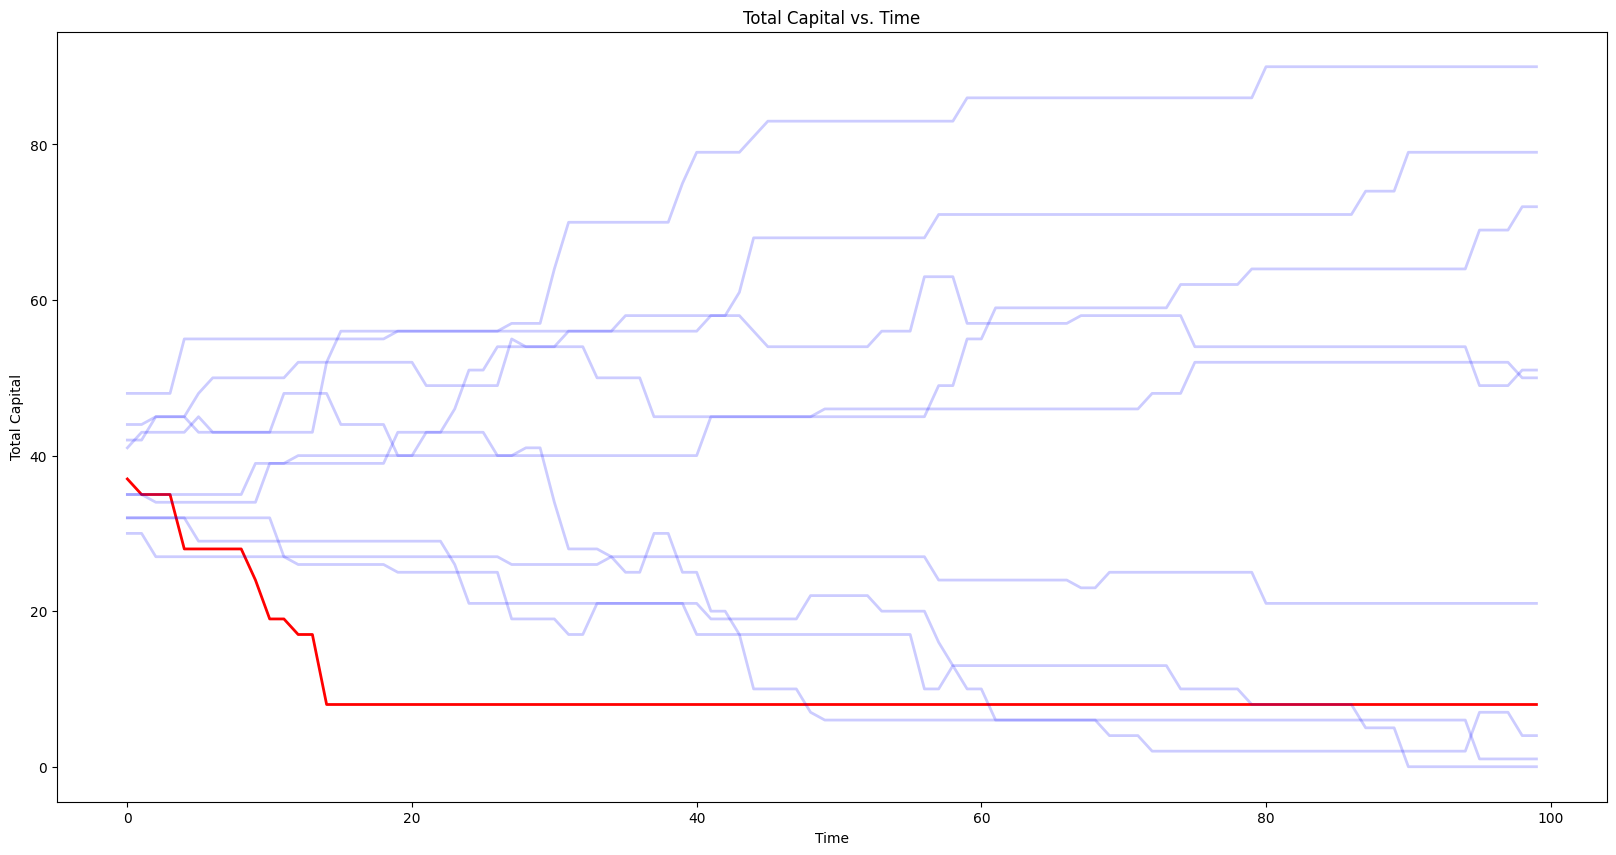

  3%|█▎                                         | 3/100 [00:46<25:00, 15.47s/it]

Episode: 165,epsilon :0.04725197423910444 Total Reward: 5


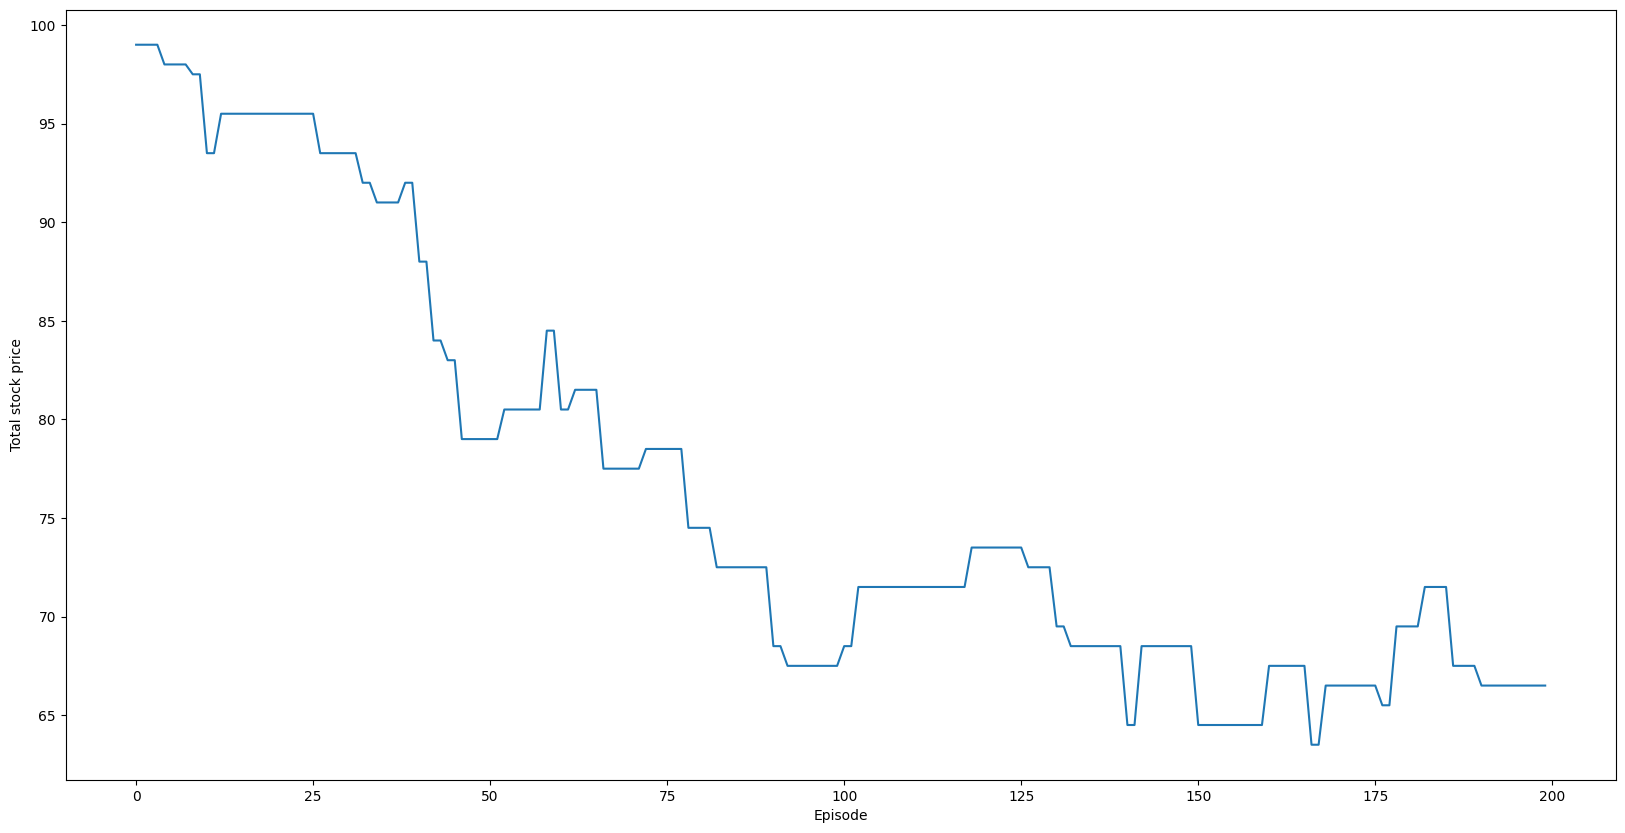

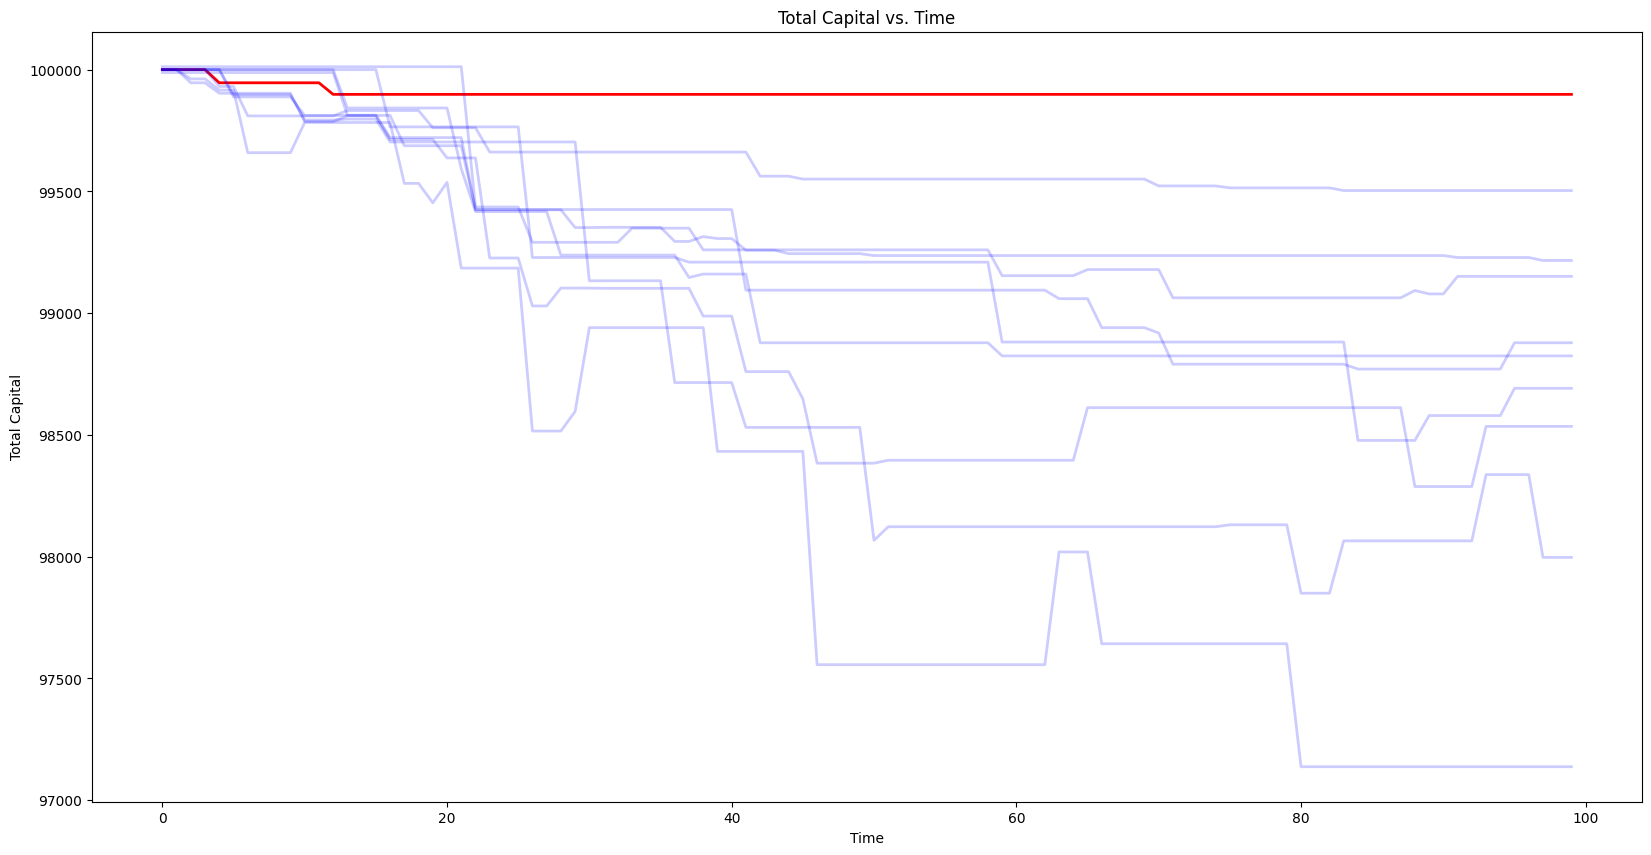

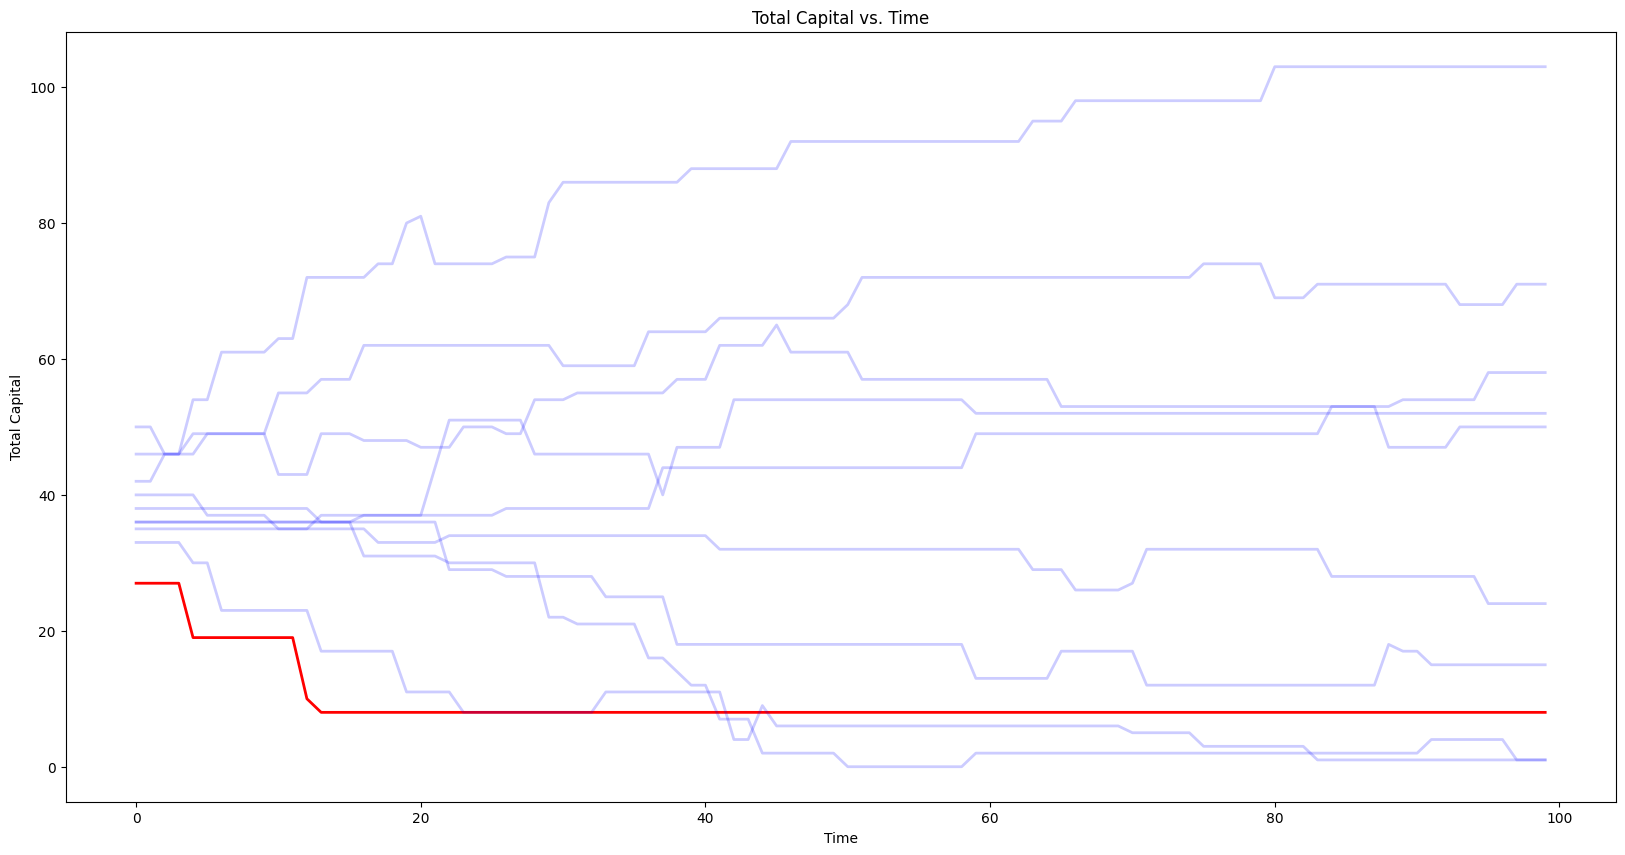

  4%|█▋                                         | 4/100 [01:03<25:24, 15.88s/it]


KeyboardInterrupt: 

In [15]:
make_env_name = 0
# make_env = True 
# load_env_name = 0
start_step = 0
target_id = 0
person_num = 10 



env = Environment(person_num  = person_num, agent_num = 0,step = 100)
env.create_person(target_id)
env.name = make_env_name
env.target_id = 0
        




episode_num  = 100
step_num = 100
rewards = []
for num in range(10):
    for ip in range(num):
        env.person_dict[ip].agent.model  = load_model('dqn_expert_{}.h5'.format(ip+1))
    for time_ in tqdm(range(episode_num)):
        episode = time_ + start_step
        state = env.reset()
        epsilon = epsilon_decay(episode)



        for step in range(step_num):

            if step == 0:
                for person in env.person_dict.values():
                    person.buy_first(random.randint(30,50)) # 첫구매


            # 행동 실행
            for person,model_id in zip(env.person_dict.values(),range(len(env.person_dict.values()))): # 주문 생성
                if model_id == 0:
                    random_ = np.random.rand()
    #                 if random_ <= epsilon: 
    #                     person.random_invest()
    #                 else:
                    person.real_agent_invest(state)

                else:
                    person.real_invest(state)




            next_state, step_reward = env.invest(target_id) #거래소 거래 진행 (마감시간)
            env.save_person_information()



    #         env.record_data([state,action,Q_values,next_state])
            state = [next_state]


            # spare reward
    #         if step == step_num - 1:
    #             env.update_Q_last(step_reward)
    #         else:
    #             env.update_Q(0)
    #         env.train()


    #         # dense reward
    #         if step == step_num - 1:
    #             env.update_Q_last(step_reward)
    #         else:
    #             env.update_Q(step_reward)
    #         env.train()

        last_step_reward = step_reward
        rewards.append(last_step_reward)
        print(f'Episode: {episode+1},epsilon :{epsilon} Total Reward: {last_step_reward}')



        #  reward             
    #     env.update_Q(last_step_reward)
    #     env.train()




    model = env.person_dict[target_id].agent.model
    model.save('final_model_env/dqn_expert_{}_dense.h5'.format(num+1))
